<a href="https://colab.research.google.com/github/gh-yana/testing1/blob/master/yana_testing_Other_1_Zinrai%E6%96%87%E5%AD%97%E5%88%97%E8%AA%8D%E8%AD%98API%EF%BC%86OpenCV_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ※※事前準備※※

In [1]:
!!pip install -U -q PyDrive

[]

In [0]:
# Google Driveアクセス準備
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Google Driveからのコピー
id = '13ZVJRHcGqgJhW4eKMbz4OHpR7dyh5V2h'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test1.png')

In [4]:
#コピーされてるか確認
!pwd
!ls

/content
adc.json  sample_data  test1.png


# Zinrai 手書文字列認識APIの基本的な使い方　<img src="https://www.fujitsu.com/jp/imagesgig5/handwritten-text-line-recognition_tcm102-3907272_tcm102-2750236-32.png" width="80">  
[手書文字列認識APIの商品情報はこちら](https://www.fujitsu.com/jp/solutions/business-technology/ai/ai-zinrai/services/platform/handwritten-text-line-recognition/index.html)




---



## はじめに（必要な作業）
<font color="Red">Zinrai手書文字列認識は、<b>「行単位で切り取られた領域内の手書き画像を、文字認識する機能」</b>です。</br>このため、OCRのように使うには以下の作業が必要となります。</font>、
1.   帳票の電子化（スキャナ、カメラ等で画像として取り込む。今回は割愛）
2.   認識箇所の切り出し（OCRソフトウェア、OSSで自作など）**※今回はサンプルとしてOpenCV(オープンソース)でコーディング**
3.   切り出した画像から文字列をテキスト認識<b><font color="Red">『Zinrai 手書文字列認識API』 ←★ここが Zinrai-API ★</font></b>

※OCRソフトウェアにはPFU製の**「[DynaEyeシリーズ](https://www.pfu.fujitsu.com/dynaeye/)」**などがあります（DynaEyeは.NET Frameworkでの開発が可能）。




---



## 認識箇所の切り出し ～OpenCV(オープンソース)＆Pythonでの実装例～

OpenCVとは
> Open Source Computer Vision Libraryとしてインテルが開発・公開したオープンソースのコンピュータビジョン向けライブラリ。画像処理・画像解析および機械学習等の機能を持つC/C++、Java、Python、MATLAB用ライブラリで、プラットフォームとしてmacOSやFreeBSD等全てのPOSIXに準拠したUnix系OS、Linux、Windows、Android、iOS等をサポートしている。

[詳細はこちら(https://opencv.org)](https://opencv.org/)




In [0]:
#モジュールインポート
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as  pd
from IPython.display import Image,display_png

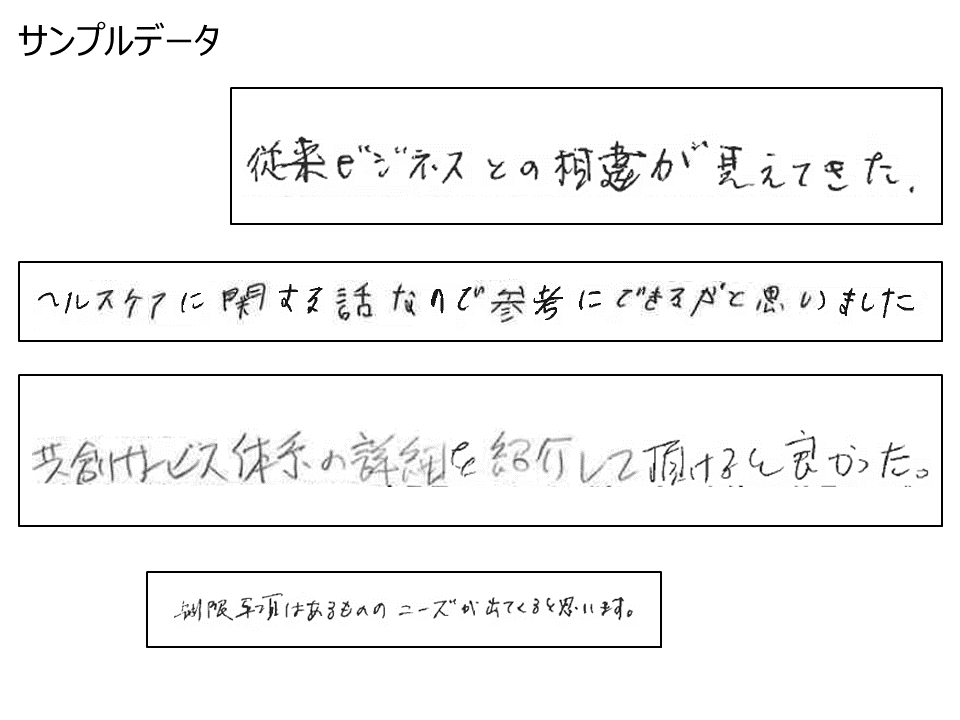

In [6]:
img = cv2.imread("/content/test1.png")    #ファイル読み込み
#plt.imshow(img,)   #元画像表示
display_png(Image("/content/test1.png"))

In [7]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    #グレースケール変換
cv2.imwrite("/content/out1_gray1.png", gray)
gray2 = cv2.bitwise_not(gray)    #ネガポジ変換
cv2.imwrite("/content/out2_gray2.png", gray2)
#plt.imshow(gray2)   #ネガポジ変換画像表示
#display_png(Image("/content/out2_gray2.png"))

True

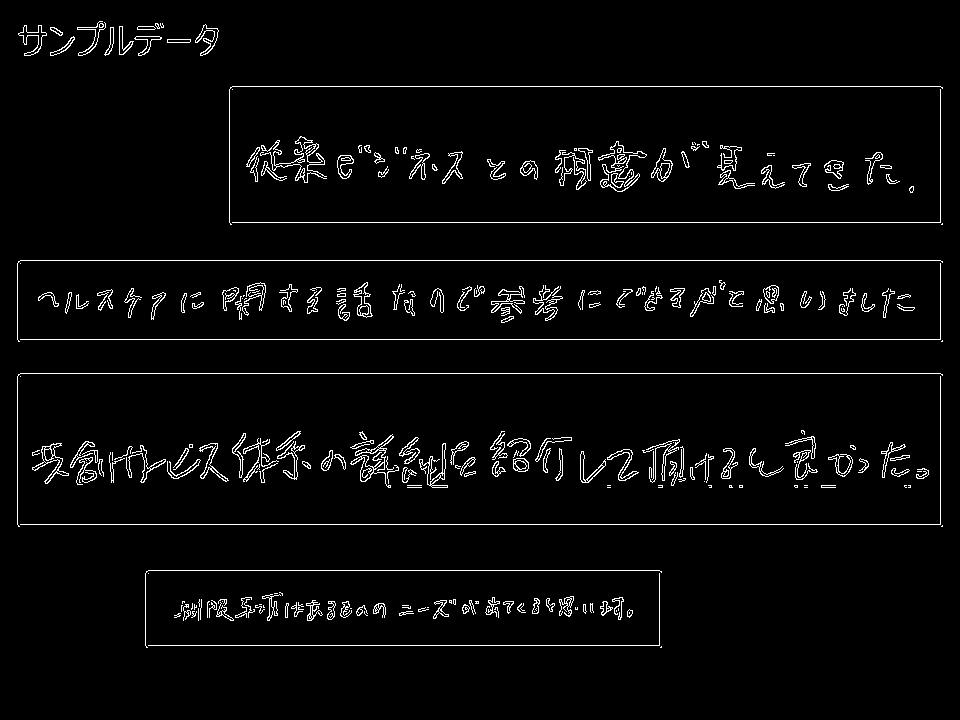

In [8]:
edges = cv2.Canny(gray, 100, 400)    #Canny法(キャニー)によるエッジ検出
cv2.imwrite("/content/out3_edges.png", edges)
#plt.imshow(edges)    #Canny法によるエッジ検出画像の表示
display_png(Image("/content/out3_edges.png"))

In [0]:
# 特徴検出の関数(HoughLinesP)で直線を検知する（確率的ハフ変換を利用して，2値画像から線分を検出）
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/360, threshold=80, minLineLength=400, maxLineGap=5)

In [0]:
# 検知した直線の座標をデータフレームに格納する
cols = ['x1', 'y1', 'x2', 'y2']
df = pd.DataFrame(index=[], columns=cols)
for line in lines:
    x1, y1, x2, y2 = line[0]
    record = pd.Series([x1, y1, x2, y2], index=df.columns)
    df = df.append(record, ignore_index=True)
#df

In [11]:
df = df.sort_values(by=['x1','y1'])
df = df.reset_index(drop=True)
df   # データフレーム（取得した座標データ）の内容を表示する

,x1,y1,x2,y2
0,17,339,940,339
1,17,524,940,524
2,20,260,940,260
3,20,373,940,373
4,145,645,659,645
5,148,570,659,570
6,229,222,940,222
7,232,86,940,86


取得した座標から、認識対象領域のみを切り出す（サンプルでは、どの配列を使うかのロジックは実装しておらず、使う配列番号は固定としている。）

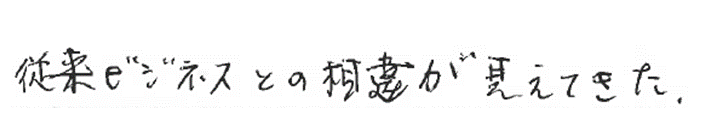

In [12]:
# 切り取り（例 1）  roi = img[y:y+h, x:x+w]　　x,y:左上座標　w,h:幅高さ
x = df.loc[7,"x1"]
y = df.loc[7,"y1"] +3  # +3は線を含ませないための暫定補正
w = df.loc[7,"x2"] - x
h = df.loc[6,"y2"] - y

img = cv2.imread("/content/test1.png")    #基ファイル読み込み
roi = img[y:y+h, x:x+w]   # 領域切り取り
#plt.imshow(roi)
cv2.imwrite("/content/cut1.png", roi)   # ファイル保存（Zinrai文字列認識で使う画像データ）
display_png(Image("/content/cut1.png"))

In [0]:
# 切り取り（例 2）  roi = img[y:y+h, x:x+w]　　x,y:左上座標　w,h:幅高さ
x = df.loc[5,"x1"]
y = df.loc[5,"y1"] +3  # +3は線を含ませないための暫定補正
w = df.loc[5,"x2"] - x
h = df.loc[4,"y2"] - y

img = cv2.imread("/content/test1.png")    #基ファイル読み込み
roi = img[y:y+h, x:x+w]   # 領域切り取り
#plt.imshow(roi)
cv2.imwrite("/content/cut1.png", roi)   # ファイル保存（Zinrai文字列認識で使う画像データ）
display_png(Image("/content/cut1.png"))

**ここまでが、ZinraiAPIを使うための前処理となる。（認識対象領域の切り出しは、ユーザ開発）**

## Zinrai APIによる手書き文字列認識 ～Pythonでの実装例～


### APIトークンの取得

ZinraiAPIを実行するためのトークン(認証情報)を取得する

In [13]:
import requests     # ライブラリインポート
import json

url = "https://auth-api.jp-east-1.paas.cloud.global.fujitsu.com/API/oauth2/token"
#payload = "grant_type=client_credentials&scope=service_contract&client_id=aiservetrial080&client_secret=55954ai4-4oss-5ea1-9a55-12754Fad5ai"   # IDとパスワードを設定
payload = "grant_type=client_credentials&scope=service_contract&client_id=aiservicetrial&client_secret=kR4H,ut9R#Ei4NEADAFcUsT_.U4FdYy*_!CnpnYx"   # IDとパスワードを設定
headers = { "content-type": "application/x-www-form-urlencoded;charset=UTF-8" }

response = requests.request("POST", url, data=payload, headers=headers)    # WebAPIの実行
#print("API RC:  ",response.status_code)
#print("レスポンスの全データ:",response.text)

json_dict = json.loads(response.text)      # 戻り値(JSON)をDICT型に変換
token = json_dict.get('access_token')      # トークンだけを取り出し
print("取得したアクセストークン ：  " ,token)

取得したアクセストークン ：   dfc61a20-9d1d-4401-ab3b-ed5b7d37f2c3


### 文字列認識したい画像データをAPIに渡すための前処理を行う（base64encode）

※WebAPI(httpプロトコル)で画像データを送るために、画像データをアスキー文字列に変換する(base64encode)。

In [14]:
import base64
temp0 = open('/content/cut1.png', 'rb').read()    #APIに渡す画像データの読み込み
b64str = base64.b64encode( temp0 )   #base64でencode
b64str = b64str.decode("ascii")   #バイナリ型からストリング型に変換
print(b64str)

iVBORw0KGgoAAAANSUhEUgAAAsQAAACFCAIAAADTrHk0AAAgAElEQVR4AezBIWAbV9ou4NfsC3vFPGwPVNmIWSwDtUxmdlFUpjD7IiuoNro2i1gUVBtdi63YP8tkpmEZeJaN2bzMH5vrqOvWaZo2ddvdtv95np2u65AkSZIkSfJUO13XIUmSJEmS5Kl2uq5DkiRJkiTJU+10XYckSZIkSZKn2um6DkmSJEmSJE+103UdkiRJkiRJnmqn6zokSZIkSZI81U7XdUiSJEmSJHmqna7rkCRJkiRJ8lQ7XdchSZIkSZLkqXa6rkOSJEmSJMlT7XRdhyRJkiRJkqfa6boOSZIkSZIkT7XTdR2SJEmSJEmeaqfrOiRJkiRJkjzVTtd1SJIkSZIkeaqdruuQJEmSJEnyVDtd1yFJkiRJkuSpdrquQ5IkSZIkyVPtdF2HJEmSJEmSp9rpug5JkiRJkiRPtdN1HZIkSZIkSZ5qp+s6JEmSJEmSPNVO13VIkiRJkiR5qp2u65AkSZIkSfJUO13XIUmSJEmS5Kl2uq5DkiRJkiTJU+10XYckSZIkSZKn2um6DkmSJEmSJE+103UdkiRJkiRJnmqn6zokSZIkSZI81U7XdUiSJEmSJHmqna7rkCRJkiRJ8lQ7XdchSZIkSZLkqXa6rkOSJEmSJMlT7XRdhyRJkiRJkqfa6boOSZIkSZIkT7XTdR2SJEmSJEmeaqfrOiRJkiRJkjzVTtd1SJIkSZIkeaqdruuQJEmSJEnyVDtd1yFJkiRJkuSpdrquQ5IkSZIkyVPtdF2HJEmSJEmSp9rpug5JkiRJkiRPtdN1HZIkSf7jJJHEliSS+AuRRBJbkkjil5NEEluSSCL5k5NEEluSSGJLEkn8ae10XYckSZL/FEkk8RcliSSeRBJJAJJIIkn+PHa6rsNfRYyxrm8y9sMXgSSSJEn+YCSRBCCJJABJJJEkf2Y7Xdfhz0/SZr1ZleWqXGW93nQ6yfO9EAKS

### 手書文字列認識を実行する

※非同期処理となるため、文字列認識APIを実行して「処理受付ID」を取得する。以降、この処理受付IDを使って、文字認識の結果を取得する。

In [15]:
url = "https://zinrai-pf.jp-east-1.paas.cloud.global.fujitsu.com/HandwrittenTextLineRecognition/v1/recognitions"   # URIとモード指定
headers = {
      "X-Service-Code": "FJAI000016-00001" ,                  #手書文字列認識モード
      "content-type": "application/json;charset=UTF-8" , 
      "X-Access-Token": "" +token+ ""                         #アクセストークン設定
      }

# Bodyデータ  ※encodeImageにbase64encodeした画像データを代入する
payload = '{\
  "singleImage": {\
    "recognitionObjects": [\
      {\
        "name": "image001",\
        "lineObject": {\
          "encodeImage": "' + b64str + '",\
          "encodeType": "base64string"\
        },\
        "option": {\
          "characterModel": "all",\
          "fieldModel": "gen_all",\
          "correction": false\
        }\
      }\
    ]\
  }\
}'
#print(headers)
#print (payload)

response = requests.request("POST", url, data=payload, headers=headers)    # WebAPIの実行
print("API RC:  ",response.status_code)
print("レスポンス:",response.text)

API RC:   202
レスポンス: {"act_id":"100039_20191009154526918"}


In [16]:
actid = response.text[11:35]    # 処理受付ID(act_id)を切り取る
print("処理受付ID:",actid)

処理受付ID: 100039_20191009154526918


### 文字列認識の「結果(テキスト文字)」を取得する。

In [18]:
url = "https://zinrai-pf.jp-east-1.paas.cloud.global.fujitsu.com/HandwrittenTextLineRecognition/v1/recognitions/" + actid   # URIとモード指定
headers = {
      "X-Service-Code": "FJAI000016-00006" ,                  #結果取り出しモード
      "content-type": "application/json;charset=UTF-8" , 
      "X-Asynchronous-CallId":"" +actid+ "" ,                 #処理受付ID(Act_id)の設定
      "X-Access-Token": "" +token+ ""                         #アクセストークン設定
      }
#print(headers)
#print (payload)

response = requests.request("GET", url, data=payload, headers=headers)    # WebAPIの実行
print("API RC:  ",response.status_code)
print("レスポンス:",response.text)

API RC:   200
レスポンス: {"status":"completed","results":{"fields":[{"name":"image001","status":"completed","lineObject":{"text":"従来ビジネスとの相違が見えてきた、","textRaw":"従来ビジネスとの相違が見えてきた、","characters":[{"character":"従","score":1.0},{"character":"来","score":0.968},{"character":"ビ","score":0.82},{"character":"ジ","score":0.98},{"character":"ネ","score":0.075},{"character":"ス","score":0.058},{"character":"と","score":0.964},{"character":"の","score":0.971},{"character":"相","score":0.156},{"character":"違","score":0.953},{"character":"が","score":0.965},{"character":"見","score":0.0},{"character":"え","score":0.709},{"character":"て","score":0.346},{"character":"き","score":0.761},{"character":"た","score":0.931},{"character":"、","score":0.115}]}}]}}


In [19]:
json_resp = json.loads(response.text)      # 戻り値(JSON)をDICT型に変換
print(json.dumps(json_resp,indent=3,ensure_ascii=False))   #jsonデータの表示

{
   "status": "completed",
   "results": {
      "fields": [
         {
            "name": "image001",
            "status": "completed",
            "lineObject": {
               "text": "従来ビジネスとの相違が見えてきた、",
               "textRaw": "従来ビジネスとの相違が見えてきた、",
               "characters": [
                  {
                     "character": "従",
                     "score": 1.0
                  },
                  {
                     "character": "来",
                     "score": 0.968
                  },
                  {
                     "character": "ビ",
                     "score": 0.82
                  },
                  {
                     "character": "ジ",
                     "score": 0.98
                  },
                  {
                     "character": "ネ",
                     "score": 0.075
                  },
                  {
                     "character": "ス",
                     "score": 0.058
                  },
                  

＜参考＞文字列認識の基となった画像データ。

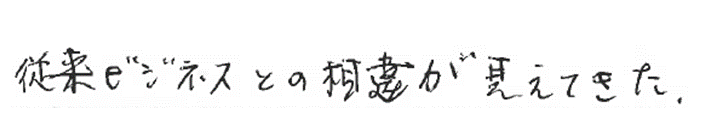

In [20]:
display_png(Image("/content/cut1.png"))